# 3D patch-based segmentation with U-Net

Code started from [Francesco's tutorials](https://github.com/FrancescoLR/tutorials)



## Imports

In [1]:
import os, sys, shutil, random, tempfile, glob, logging
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk

from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader, CacheDataset, Dataset, PatchDataset, GridPatchDataset, PatchIter, PatchIterd
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ResizeWithPadOrCropd,
    RandCropByPosNegLabeld,
    Lambdad,
    ScaleIntensityd,
    RandSpatialCropSamples,
    CropForegroundd
)
from monai.utils import first

import ignite
import torch, torchvision

print_config()

/home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1rc3
Numpy version: 1.22.4
Pytorch version: 1.12.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7a5de8b7b9db101a431e70ae2aa8ea7ebb8dfffe
MONAI __file__: /home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu116
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup 


### Paths and cuda check

In [2]:
main_dir = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/'
data_dir = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/' # train and val
test_data_dir = '/mnt/sda1/Repos/a-eye/Data'

[print(f"Main directory is: {main_dir}") if os.path.isdir(main_dir) else print("Check your data directory")]
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(torch.cuda.is_available())

Main directory is: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/
True


### Test set

Common variables

In [3]:
num_total_subjects = 35 # total number of subjects
NUM_LABELS = 9 # number of different labels (without background)

Load test subjects list from file

In [4]:
file = main_dir + 'test_subjects.txt' # test subjects list file

test_subs = [] # empty list to read list from a file

# open file and read the content in a list
with open(file, 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        test_subs.append(x)

# display list
print(test_subs)

['sub-05', 'sub-21', 'sub-25', 'sub-26']


#### Images and Labels paths

In [5]:
# Test Set
test_images = []
test_labels = []

# Test set
for i in range(len(test_subs)):
    input_t1 = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_T1_cropped.nii.gz'
    input_labels = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_labels_cropped.nii.gz'
    test_images.append(input_t1)
    test_labels.append(input_labels)

# Test dictionary
data_test_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(test_images, test_labels)
]

num_test_samples = len(data_test_dict)
print(f"Test set composed by {num_test_samples} subjects ({num_test_samples/num_total_subjects*100:.2f}%).")

Test set composed by 4 subjects (11.43%).


#### Min image size

In [6]:
''' 
Calculate the minimum and maximum axis of a set of images in a specific path
'''

# List of remaining subjects
all_subjects = list() # all the subjects (total)
for i in range(num_total_subjects):
    all_subjects.append('sub-'+str(i+1).zfill(2))

arr = [0, 0, 0] # [xmax, ymax, zmax]

for i in range(35):
    input_t1 = data_dir + 'a123/' + all_subjects[i] + '/input/' + all_subjects[i] + '_T1_cropped.nii.gz'
    n1 = nib.load(input_t1)
    if n1.shape[0] >= arr[0]:
        arr[0] = n1.shape[0]
    if n1.shape[1] >= arr[1]:
        arr[1] = n1.shape[1]
    if n1.shape[2] >= arr[2]:
        arr[2] = n1.shape[2]

print(f'(xmax, ymax, zmax) = ({arr[0]}, {arr[1]}, {arr[2]})')
min_axis = np.amax(arr)
min_axis = 96
print(f'min_axis = {min_axis}')

(xmax, ymax, zmax) = (79, 92, 80)
min_axis = 96


### Transforms

Several transforms to augment the dataset

In [7]:
# Function to crop the eye from the medical image
def masked(data_dict):
    eye_mask = (data_dict["label"] != 0)
    eye_mask[eye_mask == True] = 1
    eye_mask[eye_mask == False] = 0
    data_dict["image"] = data_dict["image"] * eye_mask

    return data_dict

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"],),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(min_axis, min_axis, min_axis)), # (96, 96, 96)
        # masked,
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=1,
        #     image_key="image",
        #     image_threshold=0,
        # ),
    ]
)

#### Check transforms in DataLoader

image shape: (1, 1, 96, 96, 96), label shape: (1, 1, 96, 96, 96)
torch unique label: 10


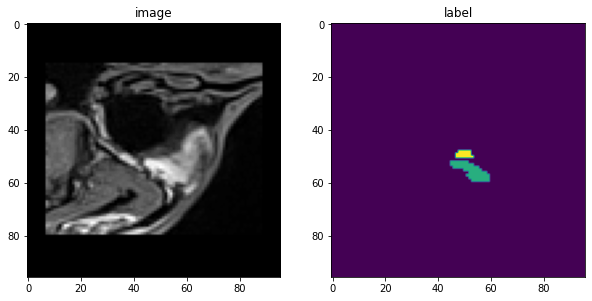

In [8]:
test_ds = Dataset(data=data_test_dict, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

check_data = first(test_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f'torch unique label: {len(torch.unique(label))}')

plt.figure("check", (10,5))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, 0, :, :, 32], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, 0, :, :, 32])
plt.show()

# Save transformed image
# im_trans = sitk.GetImageFromArray(np.transpose(image[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(im_trans, main_dir+'im_trans.nii.gz')
# lab_trans = sitk.GetImageFromArray(np.transpose(label[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(lab_trans, main_dir+'lab_trans.nii.gz')

#### Save transformed images from loader set

In [40]:
# '''
output_dir = main_dir+'Transformed_Test_Set/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Saving check_loader images
i = 1
for _, dict in enumerate(test_loader):
    # print(f"dict: {dict['image'].shape}")
    im_tensors = dict['image']
    lab_tensors = dict['label']
    # print(im_tensors[0].detach().cpu().numpy().shape)
    # print(lab_tensors[0].detach().cpu().numpy().shape)
    im_trans = sitk.GetImageFromArray(np.transpose(im_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(im_trans, output_dir+'im_trans'+str(i)+'.nii.gz')
    lab_trans = sitk.GetImageFromArray(np.transpose(lab_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(lab_trans, output_dir+'lab_trans'+str(i)+'.nii.gz')
    i += 1
    # if i == 1:
    #     break
# '''

## Create Model, Loss, Optimizer

In [10]:
# Create UNet, DiceLoss and Adam optimizer
import gc 
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = NUM_LABELS+1,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Inference

Total DSC is 0.7768800258636475. 
Total IoU score is 0.6437103152275085.
Mean dice per class (test subjects): [0.8319334983825684, 0.9276025891304016, 0.7441207766532898, 0.710444450378418, 0.6798096299171448, 0.7551314830780029, 0.7888290286064148, 0.7636502981185913, 0.7903985381126404]
Mean IoU per class (test subjects): [0.7134577035903931, 0.8655267357826233, 0.5928531289100647, 0.5523933172225952, 0.5183144211769104, 0.6088622808456421, 0.6657805442810059, 0.6187343001365662, 0.6574703454971313]


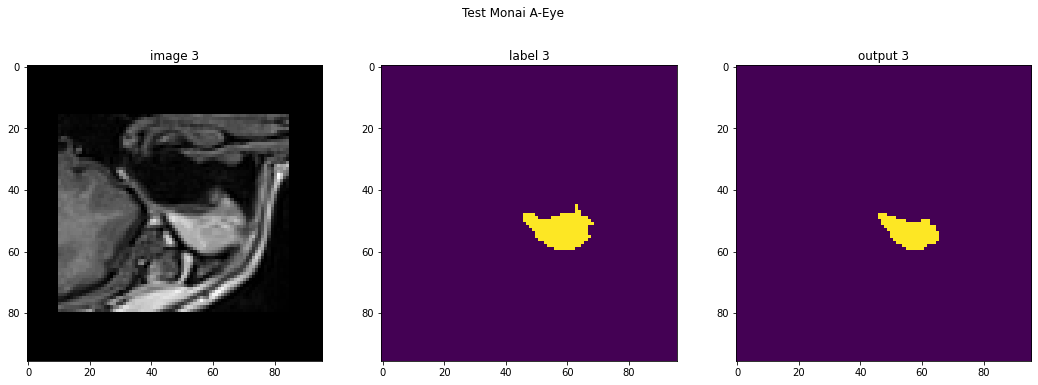

In [42]:
FILE = "v2_cropped_images.pth"

device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = NUM_LABELS+1,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

model.load_state_dict(torch.load(
    os.path.join(main_dir, FILE)))

# IoU metric
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=NUM_LABELS+1)])
post_label = Compose([AsDiscrete(to_onehot=NUM_LABELS+1)])
iou_metric = MeanIoU(include_background=False, reduction="mean")

model.eval()

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        
        roi_size = (min_axis, min_axis, min_axis)
        sw_batch_size = 4

        test_outputs_pre = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model
        )
        # print(test_outputs_pre)

        test_outputs = [post_pred(j) for j in decollate_batch(test_outputs_pre)]
        test_labels = [post_label(j) for j in decollate_batch(test_labels)]
        iou_metric(y_pred=test_outputs, y=test_labels)
        dice_metric(y_pred=test_outputs, y=test_labels)

        # plot the slice [:, :, 80]
        fig = plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :, 32], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_data["label"][0, 0, :, :, 32])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(test_outputs_pre, dim=1).detach().cpu()[0, :, :, 32])
        # print(val_outputs.shape)
        im_result = sitk.GetImageFromArray(np.transpose(torch.argmax(test_outputs_pre, dim=1).detach().cpu().numpy(), (3,2,1,0)))
        sitk.WriteImage(im_result, main_dir+'Transformed_Test_Set/result_'+str(i+1)+'.nii.gz')
        # if i == 1:
        #     break
        fig.suptitle('Test Monai A-Eye')
        # plt.show()
    
    # aggregate the final mean dice and IoU results
    dice_array = dice_metric.get_buffer()
    # print(dice_array.shape)
    # print(dice_array)
    test_metric_dice = dice_metric.aggregate().item()
    dice_metric.reset()
    iou_array = iou_metric.get_buffer() # (9, 10) --> 25 subjects and 10 classes
    # print(iou_array.shape)
    test_metric_iou = iou_metric.aggregate().item()
    iou_metric.reset()

    print(f"Total DSC is {test_metric_dice}. \nTotal IoU score is {test_metric_iou}.")
    
    # DSC per class
    dice_array_n = dice_array.transpose(0, 1) # to get in each line the DSC of each class
    dice_array_mean = []
    for i, val in enumerate(dice_array_n):
        dice_array_mean.append(torch.mean(val).item())
    print(f'Mean dice per class (test subjects): {dice_array_mean}')

    # IoU per class
    iou_array_n = iou_array.transpose(0, 1) # to get in each line the IoU of each class
    iou_array_mean = []
    for i, val in enumerate(iou_array_n):
        iou_array_mean.append(torch.mean(val).item())
    print(f'Mean IoU per class (test subjects): {iou_array_mean}')